## Read Me Section

Created by - Samir Paul

ERA1 - Assignment for "Session 11 - CAMs, LRs and Optimizers"

Dataset = CIFAR10
Used Pytorch Framework

Requirement is to use Train ResNet18 on Cifar10 for 20 Epochs  and use GradCAM to study the misclassified image


## Perform standard imports

In [51]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
import seaborn as sn  # for heatmaps
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

!pip install torch_lr_finder
from torch_lr_finder import LRFinder
import torch.optim as optim

from mytrain import  lrs
from mytrain import train_losses, train_acc
import  utils

**Importing my Custom Library - Modular Code**

In [52]:
import mymodels as mymodel
import mytrain
import mytest


In [53]:
import torchvision
import torch
import torchvision.transforms as transforms
# Albumentations for augmentations
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

cv2.setNumThreads(0)
cv2.ocl.setUseOpenCL(False)

class Cifar10SearchDataset(torchvision.datasets.CIFAR10):

    def __init__(self, root="~/data/cifar10", train=True, download=True, transform=None):

        super().__init__(root=root, train=train, download=download, transform=transform)

    def __getitem__(self, index):

        image, label = self.data[index], self.targets[index]

        if self.transform is not None:

            transformed = self.transform(image=image)

            image = transformed["image"]

        return image, label



In [54]:


train_transforms = A.Compose(
    [
        #A.HorizontalFlip(),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.CoarseDropout(max_holes=1, max_height=8, max_width=8, min_holes=1, min_height=8, min_width=8, fill_value=(0.4914, 0.4822, 0.4465), always_apply=False, p=0.5),
        A.RandomCrop(32, 32, p=4),
        #A.HorizontalFlip(p=0.5),
        A.Resize(32, 32),
        A.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010)),
        ToTensorV2(),

    ]
)

test_transforms = A.Compose(
    [
        A.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010)),
        ToTensorV2(),
    ]
)

In [55]:
train_data = Cifar10SearchDataset(root='./data', train=True,download=True, transform=train_transforms)
test_data = Cifar10SearchDataset(root='./data', train=False,download=True, transform=test_transforms)


Files already downloaded and verified
Files already downloaded and verified


In [56]:
class_names = ['plane', '  car', ' bird', '  cat', ' deer', '  dog', ' frog', 'horse', ' ship', 'truck']

In [57]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=512, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train_data, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test_data, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


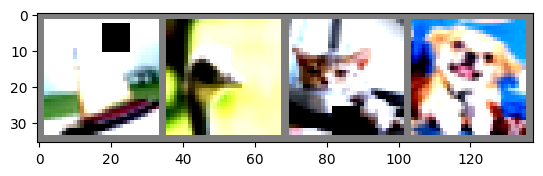

ship  bird  cat   dog  


In [58]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

import torchvision
# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [59]:
print( '+++++++++++++++++++++++ Parameters for Batch Normalization Model +++++++++++++++++++++++++++++++++++'  )
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = mymodel.ResNet18("layer").to(device)
summary(model, input_size=(3, 32, 32))

+++++++++++++++++++++++ Parameters for Batch Normalization Model +++++++++++++++++++++++++++++++++++
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
         GroupNorm-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
         GroupNorm-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
         GroupNorm-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
         GroupNorm-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
        GroupNorm-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]              

In [73]:
EPOCHS = 20
model =  mymodel.ResNet18("layer").to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum = 0.9, weight_decay=1e-2)
#optimizer = optim.Adam(model.parameters(), weight_decay=1e-2)

for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    criterion =  nn.CrossEntropyLoss()
    mytrain.train12(model, device, train_loader, optimizer, epoch, criterion)

    # scheduler.step()
    mytest.test11(model, device, test_loader)

EPOCH: 0


Loss=2.1549906730651855 Batch_id=97 Accuracy=15.16: 100%|██████████| 98/98 [00:40<00:00,  2.45it/s]



Test set:  Accuracy: 2367/10000 (23.67%)

EPOCH: 1


Loss=1.8019710779190063 Batch_id=97 Accuracy=25.33: 100%|██████████| 98/98 [00:41<00:00,  2.38it/s]



Test set:  Accuracy: 3078/10000 (30.78%)

EPOCH: 2


Loss=1.8057584762573242 Batch_id=97 Accuracy=33.81: 100%|██████████| 98/98 [00:42<00:00,  2.32it/s]



Test set:  Accuracy: 3589/10000 (35.89%)

EPOCH: 3


Loss=1.5676093101501465 Batch_id=97 Accuracy=38.43: 100%|██████████| 98/98 [00:42<00:00,  2.31it/s]



Test set:  Accuracy: 4335/10000 (43.35%)

EPOCH: 4


Loss=1.4701569080352783 Batch_id=97 Accuracy=43.07: 100%|██████████| 98/98 [00:42<00:00,  2.31it/s]



Test set:  Accuracy: 4817/10000 (48.17%)

EPOCH: 5


Loss=1.3743841648101807 Batch_id=97 Accuracy=46.77: 100%|██████████| 98/98 [00:42<00:00,  2.30it/s]



Test set:  Accuracy: 5196/10000 (51.96%)

EPOCH: 6


Loss=1.272318720817566 Batch_id=97 Accuracy=52.19: 100%|██████████| 98/98 [00:42<00:00,  2.31it/s]



Test set:  Accuracy: 5545/10000 (55.45%)

EPOCH: 7


Loss=1.2010904550552368 Batch_id=97 Accuracy=55.01: 100%|██████████| 98/98 [00:42<00:00,  2.30it/s]



Test set:  Accuracy: 6093/10000 (60.93%)

EPOCH: 8


Loss=1.147372841835022 Batch_id=97 Accuracy=55.52: 100%|██████████| 98/98 [00:42<00:00,  2.31it/s]



Test set:  Accuracy: 6167/10000 (61.67%)

EPOCH: 9


Loss=1.14004385471344 Batch_id=97 Accuracy=58.23: 100%|██████████| 98/98 [00:43<00:00,  2.28it/s]



Test set:  Accuracy: 6353/10000 (63.53%)

EPOCH: 10


Loss=1.0170221328735352 Batch_id=97 Accuracy=62.38: 100%|██████████| 98/98 [00:42<00:00,  2.30it/s]



Test set:  Accuracy: 6171/10000 (61.71%)

EPOCH: 11


Loss=0.9585551023483276 Batch_id=97 Accuracy=64.58: 100%|██████████| 98/98 [00:43<00:00,  2.28it/s]



Test set:  Accuracy: 6815/10000 (68.15%)

EPOCH: 12


Loss=1.0169841051101685 Batch_id=97 Accuracy=65.99: 100%|██████████| 98/98 [00:42<00:00,  2.31it/s]



Test set:  Accuracy: 6845/10000 (68.45%)

EPOCH: 13


Loss=0.8683629631996155 Batch_id=97 Accuracy=68.37: 100%|██████████| 98/98 [00:43<00:00,  2.28it/s]



Test set:  Accuracy: 7070/10000 (70.70%)

EPOCH: 14


Loss=0.8522933721542358 Batch_id=97 Accuracy=70.72: 100%|██████████| 98/98 [00:42<00:00,  2.31it/s]



Test set:  Accuracy: 6747/10000 (67.47%)

EPOCH: 15


Loss=0.7703312635421753 Batch_id=97 Accuracy=69.66: 100%|██████████| 98/98 [00:43<00:00,  2.28it/s]



Test set:  Accuracy: 7161/10000 (71.61%)

EPOCH: 16


Loss=0.8079648017883301 Batch_id=97 Accuracy=72.29: 100%|██████████| 98/98 [00:42<00:00,  2.31it/s]



Test set:  Accuracy: 7482/10000 (74.82%)

EPOCH: 17


Loss=0.7563881874084473 Batch_id=97 Accuracy=73.50: 100%|██████████| 98/98 [00:42<00:00,  2.28it/s]



Test set:  Accuracy: 7542/10000 (75.42%)

EPOCH: 18


Loss=0.7345125675201416 Batch_id=97 Accuracy=75.69: 100%|██████████| 98/98 [00:42<00:00,  2.31it/s]



Test set:  Accuracy: 7527/10000 (75.27%)

EPOCH: 19


Loss=0.6620785593986511 Batch_id=97 Accuracy=76.67: 100%|██████████| 98/98 [00:42<00:00,  2.29it/s]



Test set:  Accuracy: 7710/10000 (77.10%)



Classes in order Actual and Predicted


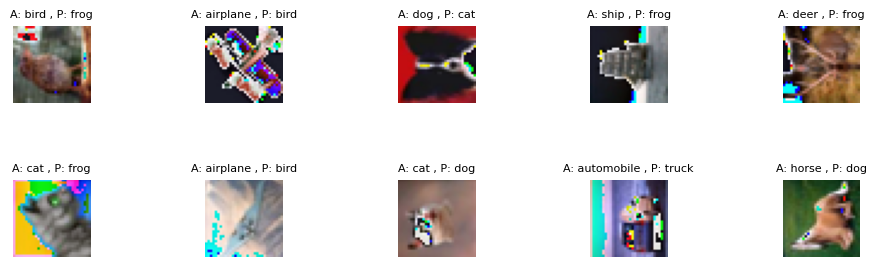

In [76]:
true_wrongs, incorrect_example, pred_incorrect = utils.get_incorrect_preds(model, test_loader)
utils.plot_incorrect_preds(true_wrongs, incorrect_example, pred_incorrect)

In [77]:
train_transform_m = transforms.Compose([transforms.ToTensor()])
train_set = datasets.CIFAR10(root='./data', train = True, download = True, transform = train_transform_m)

mean = train_set.data.mean(axis=(0,1,2))/255
std = train_set.data.std(axis=(0,1,2))/255

Files already downloaded and verified


In [78]:
wp = wrong_predictions(model, test_loader, device)

Total wrong predictions are 2290


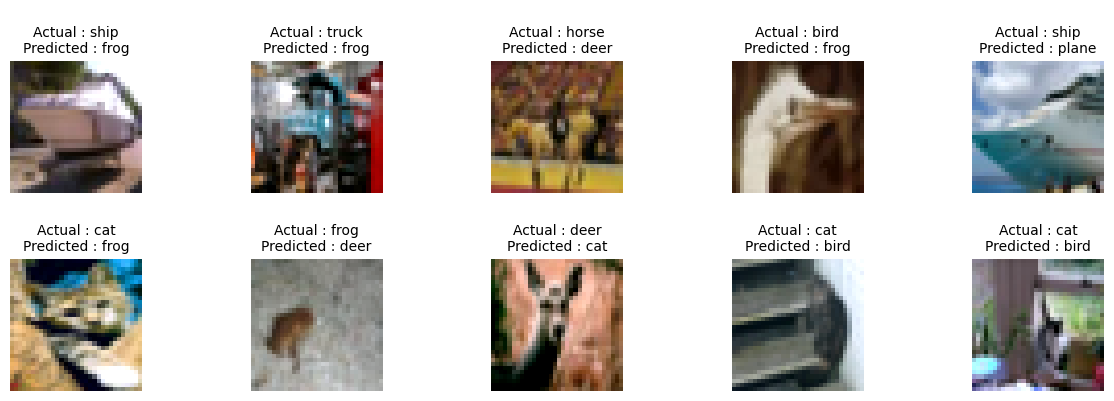

In [79]:
plot_misclassified(wp, mean, std, 10)

Generating Grad-CAM @layer4


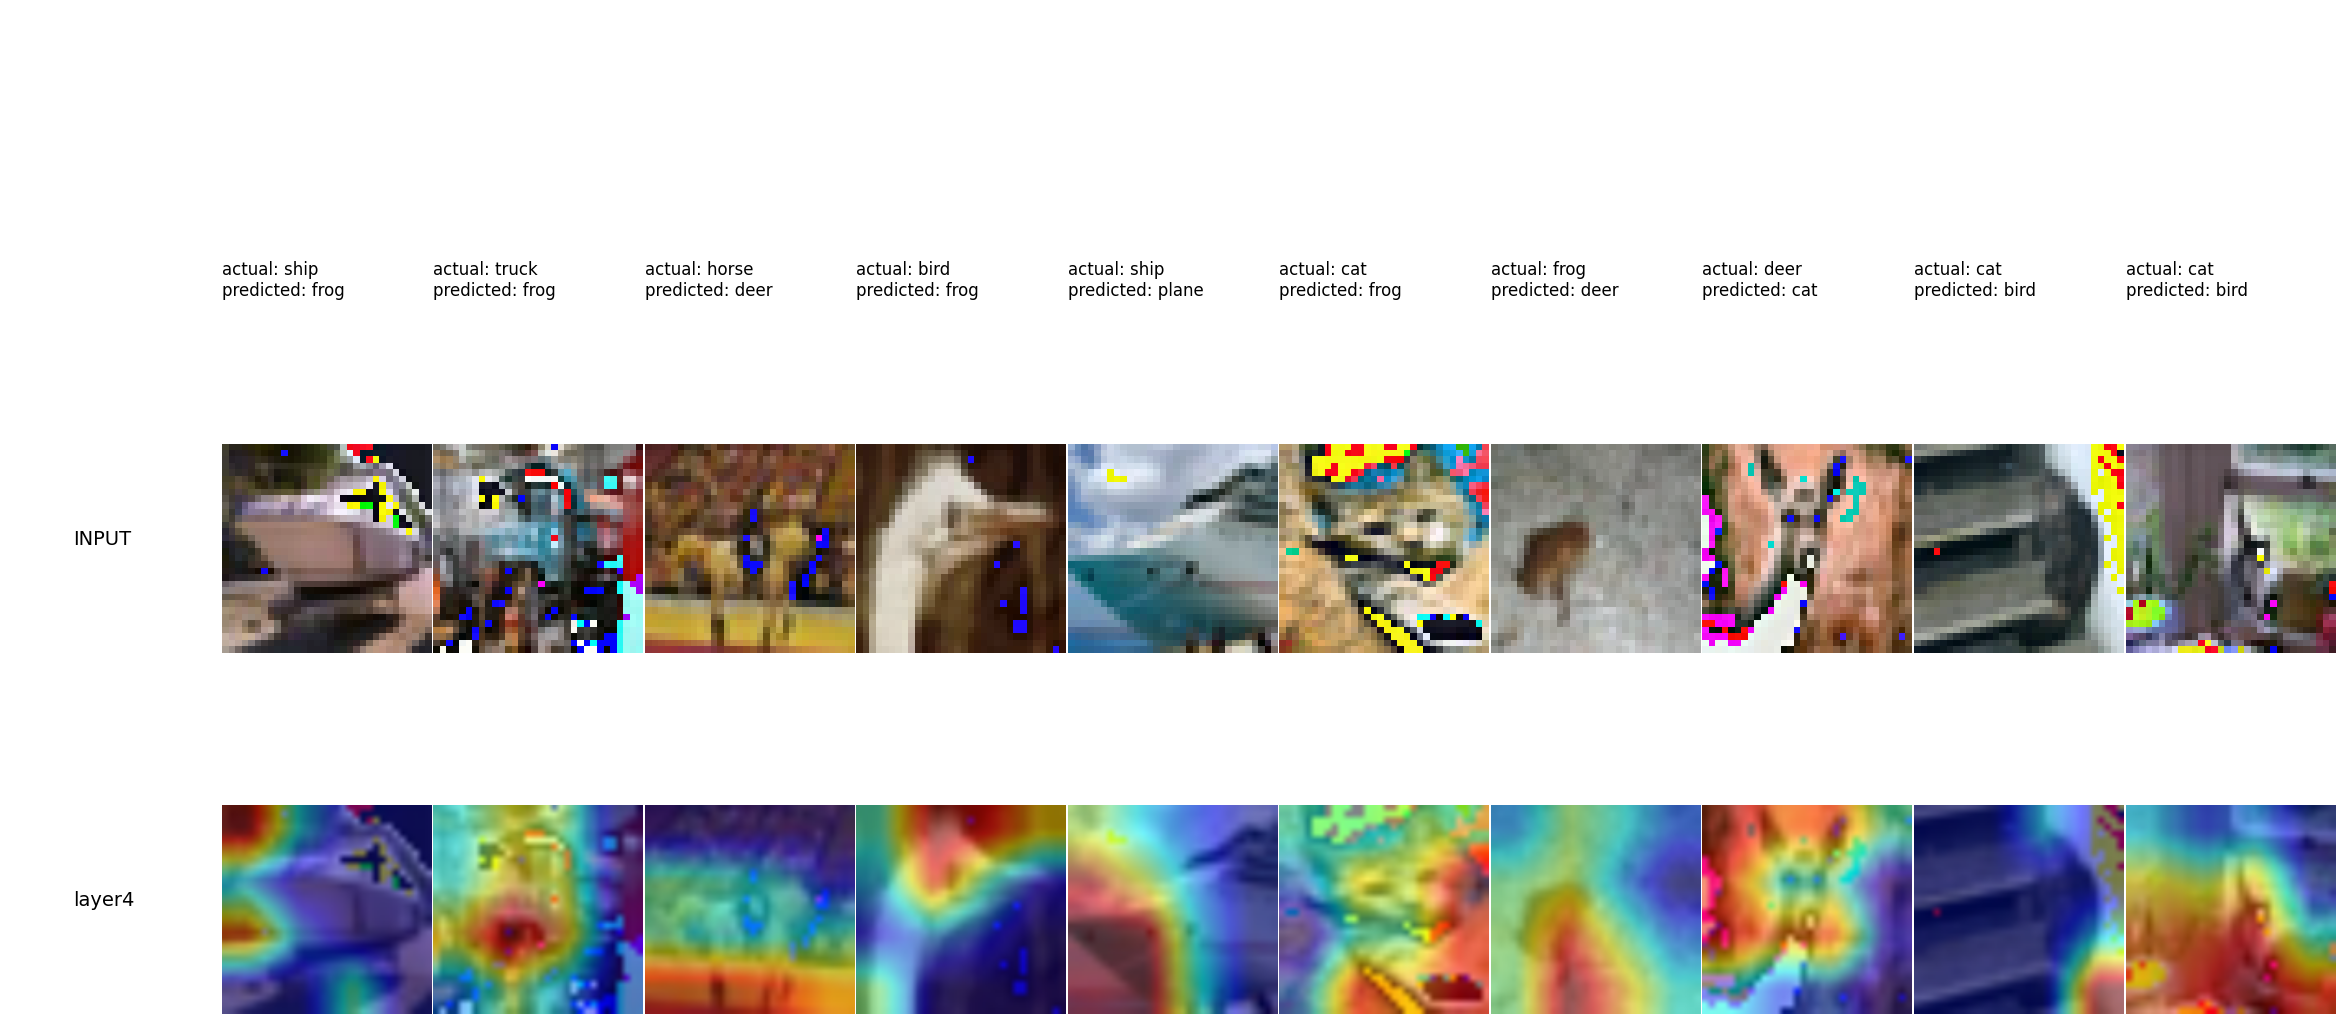

In [80]:
import gradcam
target_layers = ["layer4"]
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')
gradcam_output, probs, predicted_classes = gradcam.generate_gradcam(wp[:10], model, target_layers, device)
gradcam.plot_gradcam(gradcam_output, target_layers, classes, (3, 32, 32),predicted_classes, wp[:10], mean, std)

Generating Grad-CAM @layer4


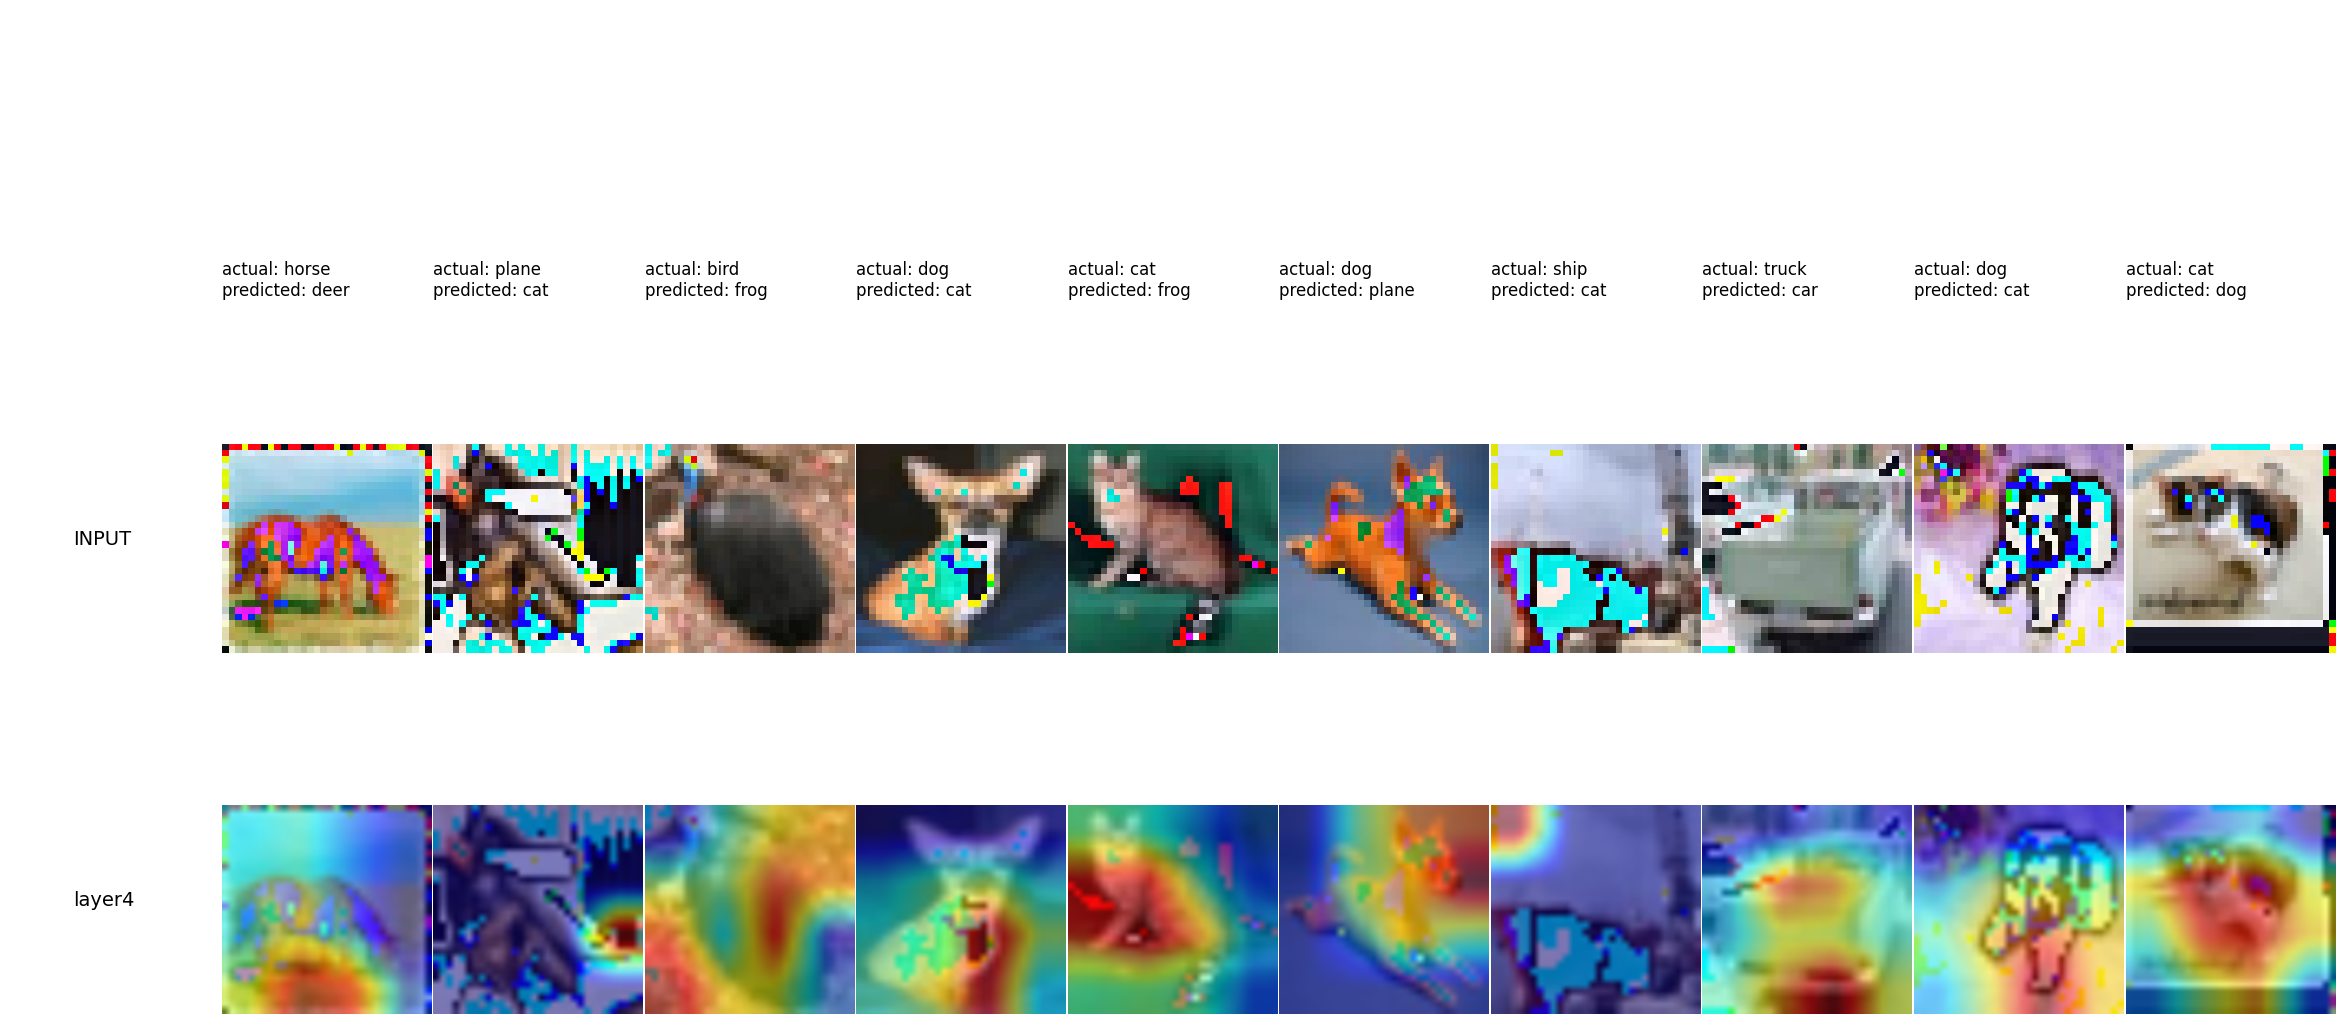

In [81]:
target_layers = ["layer4"]
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')
gradcam_output, probs, predicted_classes = gradcam.generate_gradcam(wp[10:20], model, target_layers, device)
gradcam.plot_gradcam(gradcam_output, target_layers, classes, (3, 32, 32),predicted_classes, wp[10:20], mean, std)